In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

## <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

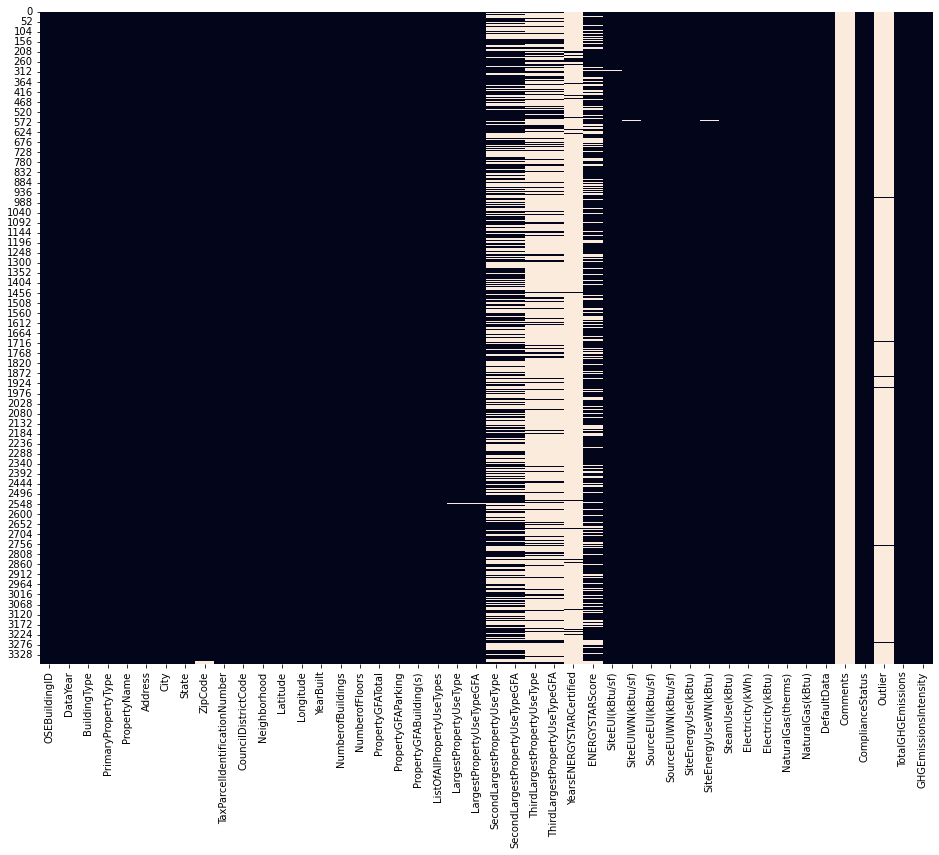

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [9]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [10]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [11]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [12]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [13]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [14]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [15]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


## <a name='C2'> Feature Engineering   </a>

In [16]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA','Campus','SPS-District K-12'] 

nonRes = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [17]:
compliant = ['Compliant']

nonRes = nonRes[nonRes['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [18]:
nonRes.shape

(1466, 46)

In [19]:
nonRes.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


In [20]:
#nonRes[nonRes['BuildingType'] == 'Campus']

In [21]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [22]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Residence Hall'].index)
#nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Other'].index)

In [23]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [24]:
nonRes.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        654
SecondLargestPropertyUseTypeGFA     654


In [25]:
nonRes['ComplianceStatus'].value_counts()

Compliant    1443
Name: ComplianceStatus, dtype: int64

In [26]:
nonRes['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [27]:
nonRes = nonRes[nonRes.Outlier.isnull()]

In [28]:
nonResidential = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

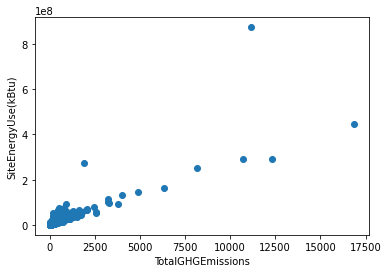

In [29]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

In [30]:
nonResidential[nonResidential['SiteEnergyUse(kBtu)'] > 600000000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
1443,University,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


- Drop des Outliers

In [31]:
nonResidential[nonResidential['TotalGHGEmissions'] > 10000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


In [32]:
# suppression des valeurs GHGE > 10000
nonResidential = nonResidential[nonResidential['TotalGHGEmissions'] < 12000]

In [33]:
# suppression des valeurs energy > 600000000
nonResidential = nonResidential[nonResidential['SiteEnergyUse(kBtu)'] < 250000000]

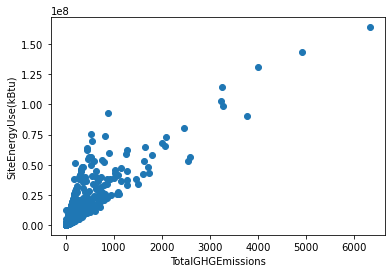

In [34]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

In [35]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [36]:
nonResidential[nonResidential['LargestPropertyUseTypeGFA'].isna()]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
281,Self-Storage Facility,47.66838,-122.39310,1946,2.0,2,111445,0,NaN,0.0,3007514.0,2689958.0,163.83,5.697472e+06
726,Hotel,47.61203,-122.34165,1910,1.0,8,61721,0,NaN,0.0,2534592.0,362488.0,36.92,2.897080e+06
1201,Small- and Mid-Sized Office,47.64747,-122.34086,2008,1.0,4,48350,0,NaN,0.0,3168131.0,0.0,22.09,3.168131e+06
1217,Restaurant,47.59697,-122.32474,1913,1.0,3,28800,0,NaN,0.0,402907.0,497017.0,29.21,8.999242e+05


In [37]:
nonResidential['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    282
Other                          189
Warehouse                      178
Large Office                   165
Mixed Use Property             104
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      22
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Laboratory                      10
Hospital                         7
Name: PrimaryPropertyType, dtype: int64

In [38]:
nonResidential = nonResidential.dropna(axis=0) 

In [39]:
nonResidential['NumberofBuildings'].value_counts()

1.0     1346
0.0       44
3.0       12
2.0       11
5.0        6
4.0        4
6.0        3
14.0       2
27.0       1
11.0       1
8.0        1
23.0       1
10.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [40]:
df1 = nonResidential.copy()

In [41]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [42]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [43]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [44]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [45]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=0) 

In [46]:
X_train, y1_train, X_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["TotalGHGEmissions"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["TotalGHGEmissions"]
X_train, y2_train, X_test, y2_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["SiteEnergyUse(kBtu)"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["SiteEnergyUse(kBtu)"]

## <a name='C2'> Prédictions de TotalGHGEmissions   </a>

In [47]:
r_forest = RandomForestRegressor(random_state=0)

In [48]:
# entrainement du modèle
r_forest.fit(X_train, y1_train)

RandomForestRegressor(random_state=0)

In [49]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y1_test,preds, squared=False))

254.35413458334773


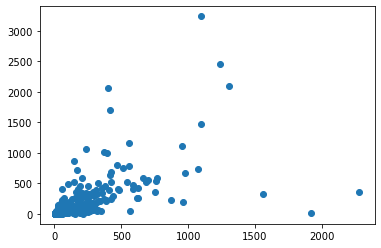

In [50]:
plt.scatter(preds,y1_test)

In [51]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=12)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [52]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  249.190288  		 MAE: 100.243628  		 R2:  0.353083
N_Estimator: 200  		 RMSE:  252.501355  		 MAE: 100.002434  		 R2:  0.335777
N_Estimator: 300  		 RMSE:  253.027870  		 MAE: 100.109885  		 R2:  0.333004
N_Estimator: 400  		 RMSE:  252.976214  		 MAE: 100.245858  		 R2:  0.333277
N_Estimator: 500  		 RMSE:  252.852935  		 MAE: 100.494374  		 R2:  0.333926


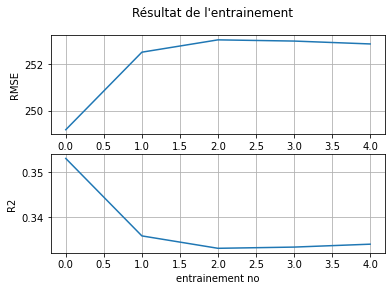

In [53]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

In [54]:
scores = []
best_scores = []

### - Dummy Regressor

In [55]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [56]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [57]:
CV_dummy_mean.best_score_

-0.007956682495047085

In [58]:
dummy_model = CV_dummy_mean.best_estimator_

In [59]:
dummy_model.score(X_test,y1_test)

-0.0005196035607379912

In [60]:
print(f"Score - training data: {round(CV_dummy_mean.score(X_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X_test,y1_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.05 %


In [61]:
scores.append(dummy_model.score(X_test,y1_test))
best_scores.append(CV_dummy_mean.best_score_)

In [62]:
res_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Random Forest Regressor


In [63]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [64]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfc.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [65]:
CV_rfc.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'random_state': 12}

In [66]:
CV_rfc.best_score_

0.4966112822023067

In [67]:
rfc_model= CV_rfc.best_estimator_

In [68]:
rfc_model.score(X_test,y1_test)

0.4016559520908808

In [69]:
print(f"Score - training data: {round(CV_rfc.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfc.score(X_test,y1_test)*100,1)} %")

Score - training data: 86.9 %
Score - test data: 40.2 %


In [70]:
scores.append(rfc_model.score(X_test,y1_test))
best_scores.append(CV_rfc.best_score_)

In [71]:
res_forest = pd.DataFrame(CV_rfc.cv_results_)

### - Ridge Regressor

In [72]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [73]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [74]:
CV_ridge.best_score_

0.4129586836880172

In [75]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=1)


In [76]:
model_ridge.score(X_test,y1_test)

0.2962100749032579

In [77]:
print(f"Score - training data: {round(CV_ridge.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X_test,y1_test)*100,1)} %")

Score - training data: 66.2 %
Score - test data: 29.6 %


In [78]:
scores.append(model_ridge.score(X_test,y1_test))
best_scores.append(CV_ridge.best_score_)

In [79]:
res_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [80]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [81]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [82]:
CV_knn.best_score_

0.2655586190098033

In [83]:
model_knn = CV_knn.best_estimator_

In [84]:
model_knn.score(X_test,y1_test)

0.3567551153475884

In [85]:
print(f"Score - training data: {round(CV_knn.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X_test,y1_test)*100,1)} %")

Score - training data: 45.8 %
Score - test data: 35.7 %


In [86]:
scores.append(model_knn.score(X_test,y1_test))
best_scores.append(CV_knn.best_score_)

In [87]:
CV_knn.best_params_

{'n_neighbors': 10}

In [88]:
res_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [89]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [90]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [91]:
CV_xgboost.best_score_

0.5028135794535414

In [92]:
model_boosted = CV_xgboost.best_estimator_

In [93]:
model_boosted.score(X_test,y1_test)

0.3762487895223583

In [94]:
y_pred = model_boosted.predict(X_test)

In [95]:
m_a_e(y1_test,y_pred)

100.18568046969544

In [96]:
r2(y1_test,y_pred)

0.3762487895223583

In [97]:
m_s_e(y1_test,y_pred,squared=False)

244.6879414542544

In [98]:
np.mean(y1_test)

151.61234883720934

In [99]:
CV_xgboost.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [100]:
print(f"Score - training data: {round(CV_xgboost.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X_test,y1_test)*100,1)} %")

Score - training data: 96.0 %
Score - test data: 37.6 %


In [101]:
model_boosted.feature_importances_

array([3.24476655e-02, 2.36260132e-02, 4.41931015e-02, 2.78064740e-02,
       1.88923584e-01, 1.18515909e-02, 2.04114067e-01, 3.10310589e-02,
       2.86104420e-04, 1.14444307e-02, 7.60195200e-05, 2.73305134e-01,
       7.56417952e-03, 1.22584580e-05, 2.66804164e-02, 3.31896962e-02,
       1.09266281e-03, 3.64789538e-03, 2.81787057e-03, 7.40162349e-06,
       8.86726034e-04, 8.05998510e-03, 3.13642802e-04, 5.29302539e-03,
       3.95578605e-03, 2.99825915e-03, 1.29160933e-02, 1.06443773e-03,
       2.42721608e-04, 3.36724768e-03, 6.46168400e-03, 9.87799359e-03,
       3.78749387e-03, 2.78103190e-03, 1.38762471e-02])

    Feature Importance                                     Feature Name
11            0.273305                     PrimaryPropertyType_Hospital
6             0.204114                        LargestPropertyUseTypeGFA
4             0.188924                           PropertyGFABuilding(s)
2             0.044193                                NumberofBuildings
15            0.033190                 PrimaryPropertyType_Large Office
0             0.032448                                         Latitude
7             0.031031                                   SteamUse(kBtu)
3             0.027806                                   NumberofFloors
14            0.026680                   PrimaryPropertyType_Laboratory
1             0.023626                                        Longitude
34            0.013876                                  YearBuilt__1920
26            0.012916                   PrimaryPropertyType_University
5             0.011852                               PropertyGFA

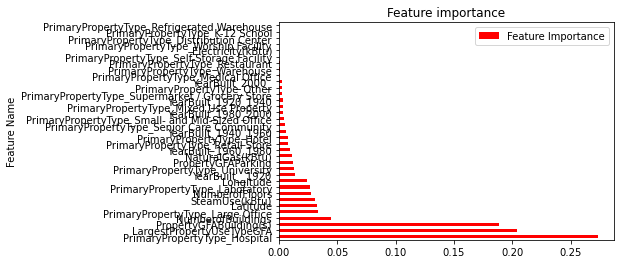

In [102]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = X_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

In [183]:
ghge_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   mode="regression",
                                                   random_state=0)

In [188]:
ghge_exp = ghge_explainer.explain_instance(data_row=X_test.iloc[18],
                                           predict_fn=CV_xgboost.predict)

In [189]:
ghge_exp.show_in_notebook(show_table=True)

In [103]:
scores.append(model_boosted.score(X_test,y1_test))
best_scores.append(CV_xgboost.best_score_)

In [104]:
res_xgboost = pd.DataFrame(CV_xgboost.cv_results_)

In [156]:
index = ['Dummy','Random Forest','Ridge','KNN','XGBoost']
columns = ['test score']
columns_b = ['validation score']

In [157]:
df_scores = pd.DataFrame(data=scores,index=index,columns=columns)
df_best_scores = pd.DataFrame(data=best_scores,index=index,columns=columns_b)

In [158]:
df_scores

,test score
Dummy,-0.000520
Random Forest,0.401656
Ridge,0.296210
KNN,0.356755
XGBoost,0.376249


In [108]:
df_best_scores

,validation score
Dummy,-0.007957
Random Forest,0.496611
Ridge,0.412959
KNN,0.265559
XGBoost,0.502814


### Energy Star Score GHGE

In [109]:
energyStar_GHGE = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','ENERGYSTARScore']]

In [110]:
energyStar_GHGE = energyStar_GHGE.dropna(axis=0)

In [111]:
energyStar_GHGE.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
ENERGYSTARScore              0
dtype: int64

In [112]:
energyStar_GHGE['YearBuilt'] = energyStar_GHGE['YearBuilt'].apply(fill_date)

In [113]:
energyStar_GHGE['SteamUse(kBtu)'] = energyStar_GHGE['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_GHGE['Electricity(kBtu)'] = energyStar_GHGE['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_GHGE['NaturalGas(kBtu)'] = energyStar_GHGE['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [114]:
energyStar_GHGE_code = pd.get_dummies(energyStar_GHGE ,columns=['PrimaryPropertyType','YearBuilt'])

In [115]:
train_EStar_ghge, test_EStar_ghge = train_test_split(energyStar_GHGE_code, test_size=0.3, random_state=0) 

- Avec Energy Star Score

In [116]:
Xe_train_ghge, ye_train_ghge, Xe_test_ghge, ye_test_ghge = train_EStar_ghge.drop(columns = ['TotalGHGEmissions']), train_EStar_ghge['TotalGHGEmissions'],test_EStar_ghge.drop(columns = ['TotalGHGEmissions']) ,test_EStar_ghge['TotalGHGEmissions']

In [117]:
rfr_eStar_ghge = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [118]:
rfr_eStar_ghge.fit(Xe_train_ghge, ye_train_ghge)

GradientBoostingRegressor(max_depth=4, max_features='sqrt', random_state=12)

In [119]:
rfr_eStar_ghge.score(Xe_test_ghge,ye_test_ghge)

0.5576401463003272

    Feature Importance                                     Feature Name
6             0.182509                        LargestPropertyUseTypeGFA
0             0.125680                                         Latitude
17            0.119713           PrimaryPropertyType_Mixed Use Property
10            0.104540                                  ENERGYSTARScore
9             0.098822                                 NaturalGas(kBtu)
4             0.086372                           PropertyGFABuilding(s)
3             0.086303                                   NumberofFloors
29            0.054923                              YearBuilt_1980_2000
1             0.045902                                        Longitude
2             0.045544                                NumberofBuildings
12            0.015582                     PrimaryPropertyType_Hospital
27            0.012588                              YearBuilt_1940_1960
7             0.005108                                   SteamUs

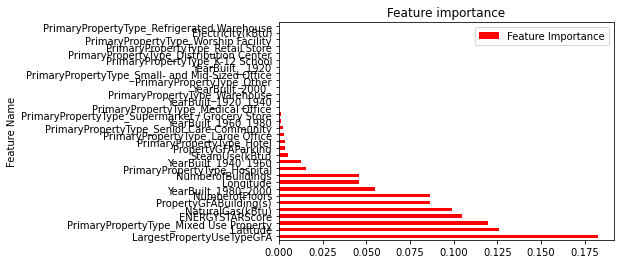

In [120]:
def display_feat_imp_xgboost(boosted):
  feat_imp = rfr_eStar_ghge.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xe_train_ghge.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(rfr_eStar_ghge)

- Sans Energy Star Score

In [121]:
Xee_train_ghge, yee_train_ghge, Xee_test_ghge, yee_test_ghge = train_EStar_ghge.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']), train_EStar_ghge['TotalGHGEmissions'],test_EStar_ghge.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']) ,test_EStar_ghge['TotalGHGEmissions']

In [122]:
rfr_eStar_ghge.fit(Xee_train_ghge,yee_train_ghge)

GradientBoostingRegressor(max_depth=4, max_features='sqrt', random_state=12)

In [123]:
rfr_eStar_ghge.score(Xee_test_ghge,yee_test_ghge)

0.697070376226307

## <a name='C2'> Prédictions de SiteEnergyUse(kbtu)   </a>

### - Dummy Regressor

In [124]:
CV_dummy_en = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [125]:
CV_dummy_en.best_score_

-0.004302227721396257

In [126]:
print(f"Score - training data: {round(CV_dummy_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.02 %


### - Random Forest

In [127]:
CV_rfr_en = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [128]:
CV_rfr_en.best_score_

0.6542656780080242

In [129]:
print(f"Score - training data: {round(CV_rfr_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_rfr_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 87.97 %
Score - test data: 68.02 %


### - Ridge Regressor

In [130]:
CV_ridge_en = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [131]:
CV_ridge_en.best_score_

0.6583247035545454

In [132]:
print(f"Score - training data: {round(CV_ridge_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_ridge_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 73.72 %
Score - test data: 58.39 %


### - KNN Regressor

In [133]:
CV_knn_en = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [134]:
CV_knn_en.best_score_

0.5628311536508491

In [135]:
print(f"Score - training data: {round(CV_knn_en.score(X_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn_en.score(X_test,y2_test)*100,1)} %")

Score - training data: 58.2 %
Score - test data: 67.2 %


### - XGBoost

In [136]:
CV_xgboost_en = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [137]:
CV_xgboost_en.best_score_

0.6695382085362752

In [138]:
CV_xgboost_en.cv_results_

{'mean_fit_time': array([0.18339877, 0.35716844, 0.53602309, 0.72954845, 0.85408697,
        0.04525242, 0.08778772, 0.13158345, 0.17804203, 0.21667404,
        0.0446878 , 0.08920746, 0.13193626, 0.17763462, 0.21856265,
        0.20879354, 0.41211767, 0.61388927, 0.83787136, 1.03695483,
        0.05298262, 0.11030583, 0.15633197, 0.20359969, 0.25392509,
        0.05218253, 0.10293961, 0.15253119, 0.20344276, 0.26160846,
        0.24702358, 0.48813949, 0.72580476, 0.97160525, 1.20620832,
        0.06139827, 0.11636767, 0.17466917, 0.23415213, 0.30007067,
        0.0596209 , 0.13027554, 0.19817905, 0.25800586, 0.29964175,
        0.2774662 , 0.56293106, 0.84689717, 1.13070297, 1.38652182,
        0.06798978, 0.13217835, 0.19637713, 0.26783571, 0.33438549,
        0.06679316, 0.13056731, 0.19440155, 0.26160598, 0.32653975,
        0.31940379, 0.63062892, 0.93821845, 1.26414919, 1.66106963,
        0.08287015, 0.15723763, 0.23840079, 0.30926723, 0.38145709,
        0.0769671 , 0.16795435,

In [139]:
print(f"Score - training data: {round(CV_xgboost_en.score(X_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost_en.score(X_test,y2_test)*100,1)} %")

Score - training data: 94.1 %
Score - test data: 63.7 %


In [190]:
energy_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                                     feature_names=X_train.columns,
                                                     mode="regression",
                                                     random_state=0)

In [191]:
energy_exp = energy_explainer.explain_instance(data_row=X_test.iloc[18],
                                               predict_fn=CV_xgboost_en.predict)

In [192]:
energy_exp.show_in_notebook(show_table=True)

### Energy Star Score Site Energy USE

In [140]:
energyStar_energy = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SiteEnergyUse(kBtu)','ENERGYSTARScore']]

In [141]:
energyStar_energy = energyStar_energy.dropna(axis=0)

In [142]:
energyStar_energy['YearBuilt'] = energyStar_energy['YearBuilt'].apply(fill_date)

In [143]:
energyStar_energy['SteamUse(kBtu)'] = energyStar_energy['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_energy['Electricity(kBtu)'] = energyStar_energy['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_energy['NaturalGas(kBtu)'] = energyStar_energy['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [144]:
energyStar_energy_code = pd.get_dummies(energyStar_energy ,columns=['PrimaryPropertyType','YearBuilt'])

- Avec Energy Star Score

In [145]:
train_EStar_energy, test_EStar_energy = train_test_split(energyStar_energy_code, test_size=0.3, random_state=0) 
Xe_train_energy, ye_train_energy, Xe_test_energy, ye_test_energy = train_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)']), train_EStar_energy['SiteEnergyUse(kBtu)'],test_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)']) ,test_EStar_energy['SiteEnergyUse(kBtu)']

In [146]:
rfr_eStar_energy = GradientBoostingRegressor(**CV_xgboost_en.best_params_)

In [147]:
rfr_eStar_energy.fit(Xe_train_energy, ye_train_energy)

GradientBoostingRegressor(max_depth=4, max_features='sqrt', random_state=12)

In [148]:
rfr_eStar_energy.score(Xe_test_energy,ye_test_energy)

0.7352213960790248

- Sans Energy Star Score

In [149]:
Xee_train_energy, yee_train_energy, Xee_test_energy, yee_test_energy = train_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)','ENERGYSTARScore']), train_EStar_energy['SiteEnergyUse(kBtu)'],test_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)','ENERGYSTARScore']) ,test_EStar_energy['SiteEnergyUse(kBtu)']

In [150]:
rfr_eStar_energy.fit(Xee_train_energy,yee_train_energy)

GradientBoostingRegressor(max_depth=4, max_features='sqrt', random_state=12)

In [151]:
rfr_eStar_energy.score(Xee_test_energy,yee_test_energy)

0.724530779591131